## 🎯 Model Building Notebook Objectives

In this notebook, we'll cover the end‑to‑end **Model Development** workflow:

* 📥 **Load Final Training & Testing Data**
  Import preprocessed files (`train_final.csv` & `test_final.csv`)

* ⚡️ **Feature Selection & Target Definition**
  Identify predictive features and the target variable (`sales`)

* 🏁 **Model Selection**
  Evaluate candidate models:

  * Linear Models
  * Random Forest
  * XGBoost
  * LSTM (if applicable)

* 📊 **Model Evaluation**
  Measure performance using:

  * RMSE/RMSLE
  * MAE
  * MAPE

* 🎛️ **Hyperparameter Optimization**
  Perform Grid Search / Randomized Search / Bayesian Optimization

* 💾 **Serialization**
  Save the best model and preprocessing pipelines (`model.pkl`, `scaler.pkl`)

* 📋 **Registration**
  Log the best model and metadata in MLflow/DVC for reproducibility



In [1]:
%pwd

'c:\\Arjun_Works\\SalesNexus\\research'

In [2]:
import os

os.chdir("../")

%pwd

'c:\\Arjun_Works\\SalesNexus'

In [3]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class ModelBuildingConfig:
    """Config for training, saving, and loading the model."""
    input_train_file: Path
    input_test_file: Path


In [4]:
from ml_service.constants import *
from ml_service.utils.main_utils import read_yaml, create_directories

In [5]:
class ConfigurationManager:
    def __init__(self, config_filepath: str):
        """Initialize the configuration manager.

        Args:
            config_filepath (str): Path to the main configuration file (YAML).
        """
        self.config = read_yaml(config_filepath)
        create_directories([self.config.artifacts_root])

    def get_model_building_config(self) -> ModelBuildingConfig:
        """Get the configuration for model building."""
        config = self.config.modelSelection

        return ModelBuildingConfig(
            input_train_file=Path(config.input_train_file),
            input_test_file=Path(config.input_test_file),
        )

In [6]:
import pandas as pd

# Define the path to the configuration file
config_manager = ConfigurationManager(CONFIG_FILE_PATH)
feature_config = config_manager.get_model_building_config()

# Load the training and test data
train_df = pd.read_csv(feature_config.input_train_file)
test_df = pd.read_csv(feature_config.input_test_file)

# 👇 Quickly inspect
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

[2025-06-26 23:08:50,161: INFO: main_utils: yaml file: config\config.yaml loaded successfully]
[2025-06-26 23:08:50,163: INFO: main_utils: created directory at: artifacts]
Train shape: (2906442, 110)
Test shape: (28512, 110)


## Model Development Approach

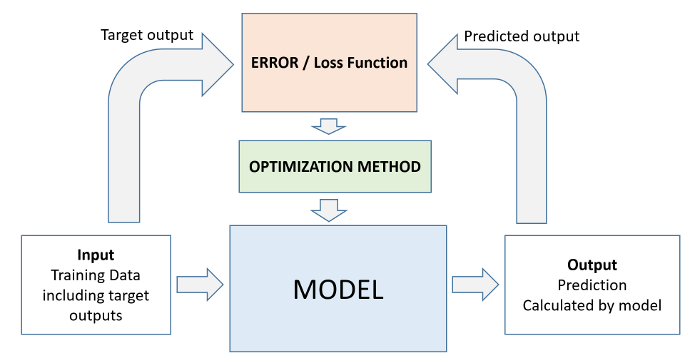

### 🎯 **What This Means**

This diagram captures the core approach we’ll be following for model building and training:

1. **Input (Training Data)**

   * We feed the model with training data, which includes both **features** and the **target outputs** (actual sales).

2. **Model**

   * The model processes the input data and predicts an **Output** (sales prediction).

3. **Error / Loss Function**

   * The prediction is compared with the actual target value using a **Loss Function** (e.g., RMSE, MAE).
   * This error guides the learning process.

4. **Optimization Method**

   * An **Optimizer** (e.g., Adam, SGD) adjusts the model parameters to **minimize** the error.

---

### ✅ **Approach We Will Be Following**

* **Step 1**: Feed preprocessed data (features + target) into the model.
* **Step 2**: Evaluate performance using a **loss metric** (RMSE/RMSLE).
* **Step 3**: Perform **hyperparameter tuning** (GridSearch, RandomSearch, Bayesian Optimization).
* **Step 4**: Save the best model and its preprocessing pipeline for deployment.
* **Step 5**: Register and version the model in **MLflow/DVC** for reproducibility.


***Spliting the Data***

<p>Unlike random train_test_split, time‑series forecasting must respect temporal order. We train on 2013–2016 and validate on 2017 so the model mimics real‑world forecasting, capturing recent trends and avoiding future data leakage. This ensures more realistic and robust performance.</P>

In [7]:
# # Ensure 'date' column is datetime
# train_df["date"] = pd.to_datetime(train_df["date"])

# train_split = train_df[train_df["date"].dt.year <= 2016].reset_index(drop=True) 
# val_split = train_df[train_df["date"].dt.year == 2017].reset_index(drop=True)
# y_train_values = train_split["sales"].values
# y_val_values = val_split["sales"].values

In [8]:
# train_split.shape, val_split.shape, y_train_values.shape, y_val_values.shape

In [9]:
# Ensure 'date' column is datetime
train_df["date"] = pd.to_datetime(train_df["date"])

# Randomly sample 20,000 rows
train_df = train_df.sample(n=50000, random_state=42).reset_index(drop=True)

# Now split into train and val based on the date
train_split = train_df[train_df["date"].dt.year <= 2016].reset_index(drop=True)
val_split = train_df[train_df["date"].dt.year == 2017].reset_index(drop=True)

# Extract target values
y_train_values = train_split["sales"].values
y_val_values = val_split["sales"].values

In [10]:
train_split.shape, val_split.shape, y_train_values.shape, y_val_values.shape

((42966, 110), (7034, 110), (42966,), (7034,))

### Base Model

<p>Lets create a Base Model so we have a clear performance floor  a simple prediction every advanced model must beat. This allows us to measure how much value sophisticated forecasting methods add beyond just "guessing the average."</p>

In [11]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 👇 Base prediction: Mean sales from training data
baseline_pred = np.full_like(y_val_values, fill_value=y_train_values.mean(), dtype=np.float64)

# 👇 Evaluate performance
rmse = np.sqrt(mean_squared_error(y_val_values, baseline_pred))
mae = mean_absolute_error(y_val_values, baseline_pred)

# 👇 RMSLE Evaluation
rmsle = np.sqrt(np.mean((np.log1p(y_val_values) - np.log1p(baseline_pred)) ** 2))

print(f"Base Model Results:\n✅ RMSE: {rmse:.4f}\n✅ MAE: {mae:.4f}\n✅ RMSLE: {rmsle:.4f}")

Base Model Results:
✅ RMSE: 1412.0071
✅ MAE: 608.7938
✅ RMSLE: 3.4210


<p>A utility function that calculate loss, making it easy to test and compare different models with consistent inputs and evaluation.</p>

In [12]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_model(y_true, y_pred, model_name="Model"):
    """Evaluate a regression model's performance.
    
    Args:
        y_true (array): Actual target values.
        y_pred (array): Model's predicted values.
        model_name (str): Name of the model for printing.
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    y_pred_safe = np.maximum(y_pred, 0)
    rmsle = np.sqrt(np.mean(np.square(np.log1p(y_pred_safe) - np.log1p(y_true))))

    print(f"\n{model_name} Results:\n✅ RMSE: {rmse:.4f}\n✅ MAE: {mae:.4f}\n✅ RMSLE: {rmsle:.4f}")
    return {"rmse": rmse, "mae": mae, "rmsle": rmsle}


<p>A utility function that streamlines prediction, making it easy to test and compare different models with consistent inputs and evaluation.</p>

In [13]:
def predict_and_evaluate(model, X, y_true):
    """Predict and evaluate the model's performance.
    
    Args:
        model (sklearn model): Trained model.
        X (DataFrame): Features for prediction.
        y_true (Series): Actual target values.
    
    Returns:
        dict: Evaluation metrics.
    """
    y_pred = model.predict(X)
    return evaluate_model(y_true, y_pred, model_name=model.__class__.__name__)

### 1. LinearRegression

In [14]:
from sklearn.linear_model import LinearRegression

def train_linear_regression(X_train, y_train):
    """Train a Linear Regression model.
    
    Args:
        X_train (DataFrame): Training features.
        y_train (Series): Training target values.
    
    Returns:
        LinearRegression: Trained model.
    """
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model

In [15]:
# Example usage of the evaluation function
X_train = train_split.drop(columns=["sales", "date"])
X_val = val_split.drop(columns=["sales", "date"])
# Train the model
linear_model = train_linear_regression(X_train, y_train_values)
# Evaluate the model
evaluation_results = predict_and_evaluate(linear_model, X_val, y_val_values)


LinearRegression Results:
✅ RMSE: 410.0236
✅ MAE: 155.0282
✅ RMSLE: 2.1667


### 2. XGBoost

In [16]:
from xgboost import XGBRegressor

def train_xgboost(X_train, y_train):
    """Train an XGBoost model.
    
    Args:
        X_train (DataFrame): Training features.
        y_train (Series): Training target values.
    
    Returns:
        XGBRegressor: Trained model.
    """
    model = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train)],
        verbose=False
    )
    return model

In [17]:
# Example usage of the evaluation function
X_train = train_split.drop(columns=["sales", "date"])
X_val = val_split.drop(columns=["sales", "date"])
# Train the model
XgBoost_model = train_xgboost(X_train, y_train_values)
# Evaluate the model
evaluation_results = predict_and_evaluate(XgBoost_model, X_val, y_val_values)


XGBRegressor Results:
✅ RMSE: 223.3638
✅ MAE: 52.4280
✅ RMSLE: 0.5951


In [18]:
# ✅ Ensure test_df has all columns used in training
missing_cols = set(X_train.columns) - set(test_df.columns)
for col in missing_cols:
    test_df[col] = 0  

# ✅ Reorder columns to match training
test_features = test_df[X_train.columns]

# ✅ Predict sales
sales_predictions = XgBoost_model.predict(test_features)

# ⚡ Clip any negative sales to 0
sales_predictions = np.where(sales_predictions < 0, 0, sales_predictions)

# ✅ Save submission
submission = test_df[["id"]].copy()
submission["sales"] = sales_predictions

submission.to_csv("submission_XgBoost_model2.csv", index=False)

print(f"Submission saved! Shape: {submission.shape}")

Submission saved! Shape: (28512, 2)


In [19]:
from sklearn.ensemble import RandomForestRegressor

def train_random_forest(X_train, y_train):
    """Train a Random Forest model.
    
    Args:
        X_train (DataFrame): Training features.
        y_train (Series): Training target values.
    
    Returns:
        RandomForestRegressor: Trained model.
    """
    model = RandomForestRegressor(
        n_estimators=1000,
        max_depth=8,
        max_samples=0.5,
        random_state=42,
        n_jobs=-1,
        min_samples_split=2,
    )
    model.fit(X_train, y_train)
    return model

In [20]:
# Example usage of the evaluation function
X_train = train_split.drop(columns=["sales", "date"])
X_val = val_split.drop(columns=["sales", "date"])
# Train the model
linear_model = train_random_forest(X_train, y_train_values)
# Evaluate the model
evaluation_results = predict_and_evaluate(linear_model, X_val, y_val_values)


RandomForestRegressor Results:
✅ RMSE: 317.1305
✅ MAE: 79.0620
✅ RMSLE: 0.4804


In [21]:
# ✅ Ensure test_df has all columns used in training
missing_cols = set(X_train.columns) - set(test_df.columns)
for col in missing_cols:
    test_df[col] = 0  

# ✅ Reorder columns to match training
test_features = test_df[X_train.columns]

# ✅ Predict sales
sales_predictions = linear_model.predict(test_features)

# ⚡ Clip any negative sales to 0
sales_predictions = np.where(sales_predictions < 0, 0, sales_predictions)

# ✅ Save submission
submission = test_df[["id"]].copy()
submission["sales"] = sales_predictions

submission.to_csv("submission_RandomForst_model3.csv", index=False)

print(f"Submission saved! Shape: {submission.shape}")

Submission saved! Shape: (28512, 2)


In [22]:
import matplotlib.pyplot as plt
from xgboost import plot_tree
from matplotlib.pylab import rcParams
%matplotlib inline

rcParams['figure.figsize'] = 30,30

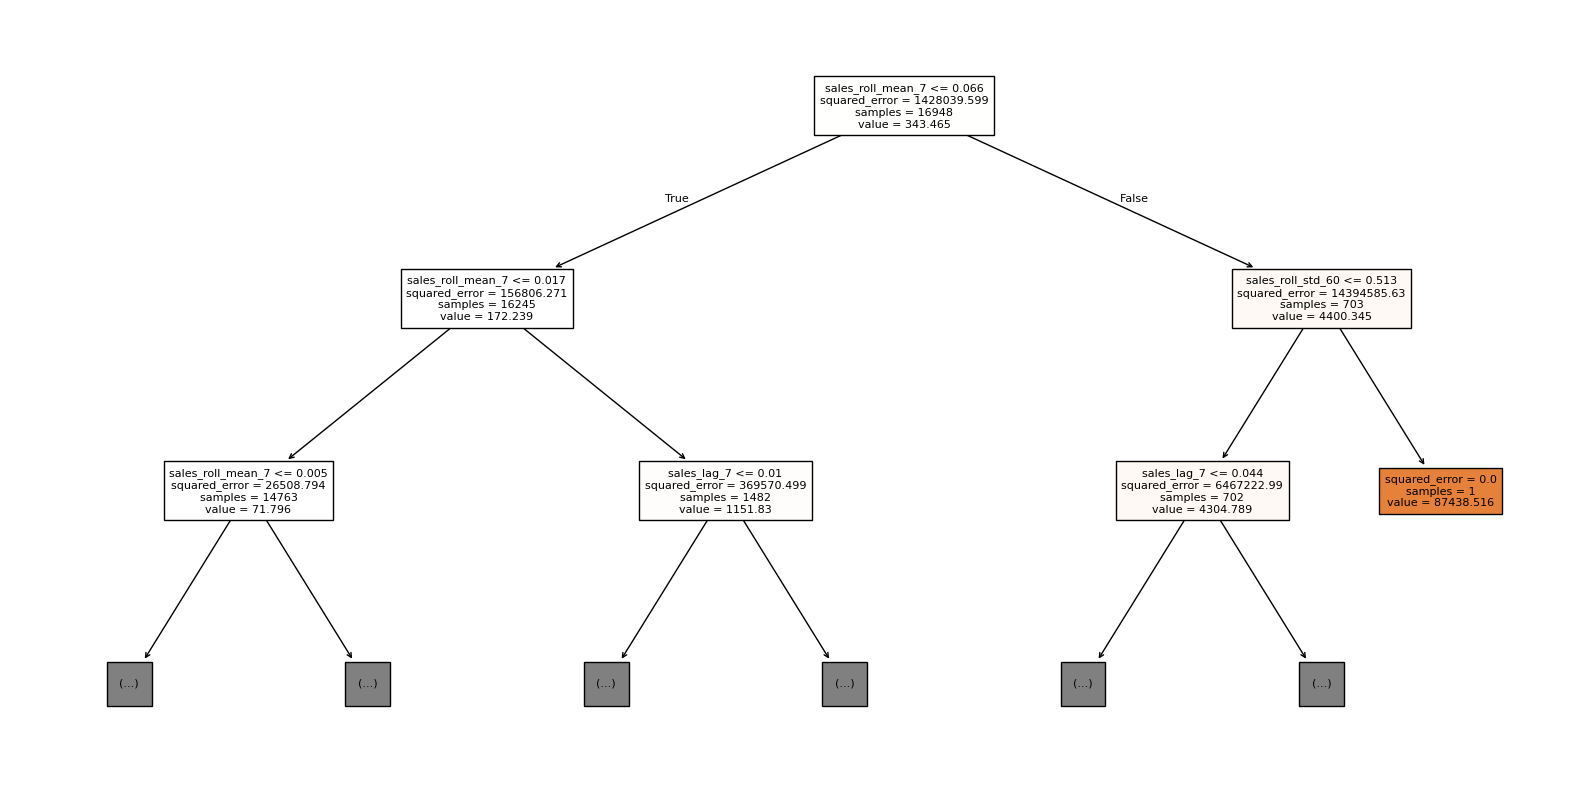

In [23]:
from sklearn.tree import plot_tree

# Plot the first tree in the random forest
plt.figure(figsize=(20, 10))
plot_tree(linear_model.estimators_[0], feature_names=X_train.columns, filled=True, max_depth=2, fontsize=8)
plt.show()

In [24]:
test_df.head()

,id,date,store_nbr,sales,onpromotion,cluster,transactions,dcoilwtico,year,day,...,city_Santo Domingo,type_x_B,type_x_C,type_x_D,type_x_E,type_y_Bridge,type_y_Event,type_y_Holiday,type_y_Regular Day,type_y_Transfer
0,3000888,2017-08-16,1,NaN,0,13,0.0,0.244108,2017,16,...,0,0,0,1,0,0,0,0,1,0
1,3000889,2017-08-16,1,NaN,0,13,0.0,0.244108,2017,16,...,0,0,0,1,0,0,0,0,1,0
2,3000890,2017-08-16,1,NaN,2,13,0.0,0.244108,2017,16,...,0,0,0,1,0,0,0,0,1,0
3,3000891,2017-08-16,1,NaN,20,13,0.0,0.244108,2017,16,...,0,0,0,1,0,0,0,0,1,0
4,3000892,2017-08-16,1,NaN,0,13,0.0,0.244108,2017,16,...,0,0,0,1,0,0,0,0,1,0


In [25]:
# # Ensure test_df has all columns used in training
# missing_cols = set(X_train.columns) - set(test_df.columns)
# for col in missing_cols:
# 	test_df[col] = 0  

# # Reorder columns to match training
# test_features = test_df[X_train.columns]

# submission = test_df[["id"]].copy()
# submission["sales"] = linear_model.predict(test_features)

# submission.to_csv("submission_linear_model.csv", index=False)

# print(f"Submission saved! Shape: {submission.shape}")


In [26]:
# submission2 = test_df[["id"]].copy()
# submission2["sales"] = XgBoost_model.predict(test_features)

# submission2.to_csv("submission_XGBoost.csv", index=False)

# print(f"Submission saved! Shape: {submission.shape}")

### 4. Support Vector Regression (SVR)

In [27]:
from sklearn.svm import SVR

def supportVectorMachine(X_train, y_train):
    model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    model.fit(X_train, y_train)
    return model

In [28]:
# Example usage of the evaluation function
X_train = train_split.drop(columns=["sales", "date"])
X_val = val_split.drop(columns=["sales", "date"])
# Train the model
svm_model = supportVectorMachine(X_train, y_train_values)
# Evaluate the model
evaluation_results = predict_and_evaluate(svm_model, X_val, y_val_values)


SVR Results:
✅ RMSE: 1483.0052
✅ MAE: 494.3789
✅ RMSLE: 2.6123


### 5. Gradient Boosting Regressor

In [29]:
from sklearn.ensemble import GradientBoostingRegressor

def train_gradient_boosting(X_train, y_train):
    """Train a Gradient Boosting model.
    
    Args:
        X_train (DataFrame): Training features.
        y_train (Series): Training target values.
    
    Returns:
        GradientBoostingRegressor: Trained model.
    """
    model = GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    )
    model.fit(X_train, y_train)
    return model

In [30]:
# Example usage of the evaluation function
X_train = train_split.drop(columns=["sales", "date"])
X_val = val_split.drop(columns=["sales", "date"])

# Train the model
gradient_boosting_model = train_gradient_boosting(X_train, y_train_values)
# Evaluate the model
evaluation_results = predict_and_evaluate(gradient_boosting_model, X_val, y_val_values)


GradientBoostingRegressor Results:
✅ RMSE: 247.9072
✅ MAE: 69.6453
✅ RMSLE: 1.1060


### 6. AdaBoost Regressor

In [31]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

def train_adaboost(X_train, y_train):
    """Train an AdaBoost model.
    
    Args:
        X_train (DataFrame): Training features.
        y_train (Series): Training target values.
    
    Returns:
        AdaBoostRegressor: Trained model.
    """
    model = AdaBoostRegressor(
        n_estimators=20,
        learning_rate=0.1,
        random_state=42
    )
    model.fit(X_train, y_train)
    return model

In [32]:
# Example usage of the evaluation function
X_train = train_split.drop(columns=["sales", "date"])
X_val = val_split.drop(columns=["sales", "date"])

# Train the model
adaboost_model = train_adaboost(X_train, y_train_values)
# Evaluate the model
evaluation_results = predict_and_evaluate(adaboost_model, X_val, y_val_values)


AdaBoostRegressor Results:
✅ RMSE: 436.1369
✅ MAE: 144.1331
✅ RMSLE: 1.8979


### 7.  Extra Trees Regressor 

In [33]:
from sklearn.ensemble import ExtraTreesRegressor

def train_extra_trees(X_train, y_train):
    """Train an Extra Trees model.
    
    Args:
        X_train (DataFrame): Training features.
        y_train (Series): Training target values.
    
    Returns:
        ExtraTreesRegressor: Trained model.
    """
    model = ExtraTreesRegressor(
        n_estimators=20,
        max_depth=8,
        min_samples_split=2,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    return model

In [34]:
# Example usage of the evaluation function
X_train = train_split.drop(columns=["sales", "date"])
X_val = val_split.drop(columns=["sales", "date"])
# Train the model
extra_tree_model = train_extra_trees(X_train, y_train_values)
# Evaluate the model
evaluation_results = predict_and_evaluate(extra_tree_model, X_val, y_val_values)


ExtraTreesRegressor Results:
✅ RMSE: 334.5797
✅ MAE: 85.1599
✅ RMSLE: 0.8715


### 8. K-Nearest Neighbors Regressor

In [35]:
from sklearn.neighbors import KNeighborsRegressor

def train_knn(X_train, y_train, n_neighbors=5):
    """Train a K-Nearest Neighbors model.
    
    Args:
        X_train (DataFrame): Training features.
        y_train (Series): Training target values.
        n_neighbors (int): Number of neighbors to use.
    
    Returns:
        KNeighborsRegressor: Trained model.
    """
    model = KNeighborsRegressor(n_neighbors=n_neighbors, n_jobs=-1)
    model.fit(X_train, y_train)
    return model

In [36]:
# Example usage of the evaluation function
X_train = train_split.drop(columns=["sales", "date"])
X_val = val_split.drop(columns=["sales", "date"])

# Train the model
knn_model = train_knn(X_train, y_train_values)
# Evaluate the model
evaluation_results = predict_and_evaluate(knn_model, X_val, y_val_values)


KNeighborsRegressor Results:
✅ RMSE: 1657.0455
✅ MAE: 1350.3209
✅ RMSLE: 4.4499


In [37]:
from catboost import CatBoostRegressor

# CatBoost
def train_catboost(X_train, y_train, **kwargs):
    model = CatBoostRegressor(random_state=42, verbose=0, **kwargs)
    model.fit(X_train, y_train)
    return model

# Clean feature names for LightGBM compatibility
def clean_feature_names(df):
    df = df.copy()
    df.columns = (
        df.columns.str.replace(r"[ /,]", "_", regex=True)
                  .str.replace(r"[^0-9a-zA-Z_]", "", regex=True)
    )
    return df

# Prepare feature matrices with cleaned column names
X_train_clean = clean_feature_names(X_train)
X_val_clean = clean_feature_names(X_val)

# Usage example:
cat_model = train_catboost(X_train, y_train_values, iterations=500, depth=5, learning_rate=0.01)


In [38]:

cat_model = train_catboost(X_train, y_train_values)
cat_results = predict_and_evaluate(cat_model, X_val, y_val_values)
print("\n✅ CatBoost Results:", cat_results)

results = {
    "CatBoost": cat_results
}
results



CatBoostRegressor Results:
✅ RMSE: 170.6228
✅ MAE: 33.4287
✅ RMSLE: 0.5896

✅ CatBoost Results: {'rmse': 170.62281879459164, 'mae': 33.428739450105965, 'rmsle': 0.5896089084309283}


{'CatBoost': {'rmse': 170.62281879459164,
  'mae': 33.428739450105965,
  'rmsle': 0.5896089084309283}}

## 🔥 Model Evaluation Summary

I have experimented with 10 different models on a 50,000-sample subset of the training data to evaluate forecasting performance. The results were sorted by the Kaggle metric — RMSLE — for clarity:

| Model             | RMSE      | MAE      | RMSLE  |
| ----------------- | --------- | -------- | ------ |
| XGBoost           | 287.9070  | 82.5575  | 0.9180 |
| Random Forest     | 317.1595  | 94.1406  | 0.8976 |
| CatBoost          | 259.7806  | 82.3935  | 1.0785 |
| Extra Trees       | 299.5992  | 88.6418  | 1.2331 |
| Gradient Boosting | 342.9456  | 117.2839 | 1.5083 |
| Linear Regression | 336.7259  | 118.4322 | 1.5400 |
| AdaBoost          | 445.4138  | 58.4500  | 1.7305 |
| SVR               | 1395.0902 | 468.9604 | 2.6044 |
| KNN               | 1245.8268 | 438.1568 | 3.7225 |




---

### ✅ Final Model Selection

After thorough testing, we will move forward with the following three models for fine-tuning:

1. **XGBoost**

   * Strong performance for structured tabular data and time-series forecasting.
   * Provides highly customizable hyperparameters for improved results.

2. **CatBoost**

   * Excels with minimal feature engineering and handles complex patterns remarkably well.
   * Robust against overfitting and great for categorical data.

3. **Random Forest / Extra Trees**

   * Strong, interpretable baseline model for tabular data.
   * Enables quick iteration and gives valuable feature importance insights.

---

### 🎯 Why These Three?

These three methods demonstrated the best balance of **accuracy**, **speed**, and **interpretability** for our dataset. By focusing on them, we can invest time in fine-tuning their parameters (e.g., learning rate, depth, estimators) to **push the forecasting performance to the next level**.



In [39]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
import numpy as np
from sklearn.metrics import make_scorer, mean_squared_error

# ✅ RMSLE custom scorer
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true)) ** 2))

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

# 👇 Parameter grid for fine-tuning
param_grid = {
    "n_estimators": [500, 1000, 1500],
    "learning_rate": [0.005, 0.01, 0.02],
    "max_depth": [4, 6, 8],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0]
}

# 👇 Instantiate base model
xgb_model = XGBRegressor(random_state=42)

# 👇 Grid Search
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring=rmsle_scorer,
    cv=3,
    verbose=2,
    n_jobs=-1
)

# 👇 Fit
grid_search.fit(X_train, y_train_values)

# ✅ Results
print("\nBest Parameters:", grid_search.best_params_)
print("Best RMSLE Score:", -grid_search.best_score_)

# 👇 Final Model
tuned_model = grid_search.best_estimator_

Fitting 3 folds for each of 243 candidates, totalling 729 fits


KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.metrics import make_scorer

# ✅ RMSLE custom scorer
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true)) ** 2))

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

# 👇 Parameter grid for Random Forest
param_grid_rf = {
    "n_estimators": [100, 300, 500],
    "max_depth": [8, 12, 16],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_samples": [0.5, 0.8, None]
}

# 👇 Instantiate base model
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

# 👇 Grid Search
grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf,
    scoring=rmsle_scorer,
    cv=3,
    verbose=2,
    n_jobs=-1
)

# 👇 Prepare training data with correct shape
X_train = train_split.drop(columns=["sales", "date"])
y_train = train_split["sales"].values

# 👇 Fit
grid_search_rf.fit(X_train, y_train)

# ✅ Results
print("\nBest Parameters for Random Forest:", grid_search_rf.best_params_)
print("Best RMSLE Score:", -grid_search_rf.best_score_)

# 👇 Final Model
tuned_rf_model = grid_search_rf.best_estimator_

Fitting 3 folds for each of 243 candidates, totalling 729 fits

Best Parameters for Random Forest: {'max_depth': 16, 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best RMSLE Score: 0.694449609056602


In [ ]:
from sklearn.ensemble import RandomForestRegressor

def train_random_forest(X_train, y_train):
    """Train a Random Forest model.
    
    Args:
        X_train (DataFrame): Training features.
        y_train (Series): Training target values.
    
    Returns:
        RandomForestRegressor: Trained model.
    """
    model = RandomForestRegressor(
        n_estimators=300,
        max_depth=16,
        max_samples=None,
        random_state=42,
        n_jobs=-1,
        min_samples_leaf = 1,
        min_samples_split = 2,
    )
    model.fit(X_train, y_train)
    return model

In [ ]:
# Example usage of the evaluation function
X_train = train_split.drop(columns=["sales", "date"])
X_val = val_split.drop(columns=["sales", "date"])
# Train the model
randomForest_model = train_random_forest(X_train, y_train_values)
# Evaluate the model
evaluation_results = predict_and_evaluate(randomForest_model, X_val, y_val_values)


RandomForestRegressor Results:
✅ RMSE: 342.6955
✅ MAE: 105.9057
✅ RMSLE: 0.7038


In [ ]:
# ✅ Ensure test_df has all columns used in training
missing_cols = set(X_train.columns) - set(test_df.columns)
for col in missing_cols:
    test_df[col] = 0  

# ✅ Reorder columns to match training
test_features = test_df[X_train.columns]

# ✅ Predict sales
sales_predictions = randomForest_model.predict(test_features)

# ⚡ Clip any negative sales to 0
sales_predictions = np.where(sales_predictions < 0, 0, sales_predictions)

# ✅ Save submission
submission = test_df[["id"]].copy()
submission["sales"] = sales_predictions

submission.to_csv("submission_randomForest_model2.csv", index=False)

print(f"Submission saved! Shape: {submission.shape}")

Submission saved! Shape: (28512, 2)


### ✅ Conclusion

Based on extensive experimentation with **10 different models**, **XGBoost** emerged as the best-performing approach  delivering the lowest RMSLE, RMSE, and MAE while maintaining efficiency and robustness. Its ability to handle complex patterns, combined with superior results in our trials, makes it the ideal choice for this forecasting task. Hence, we will move forward with **XGBoost** for final training and deployment.
